# PRACTICA 4
## Diego Fernando Valle Morales
## Carné: 20003022

Empezamos importando las librerías

In [40]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import time
%reload_ext tensorboard

In [41]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

In [23]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

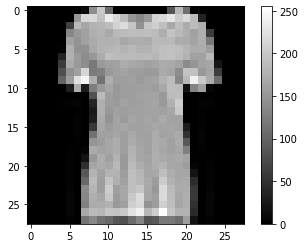

In [8]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [10]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

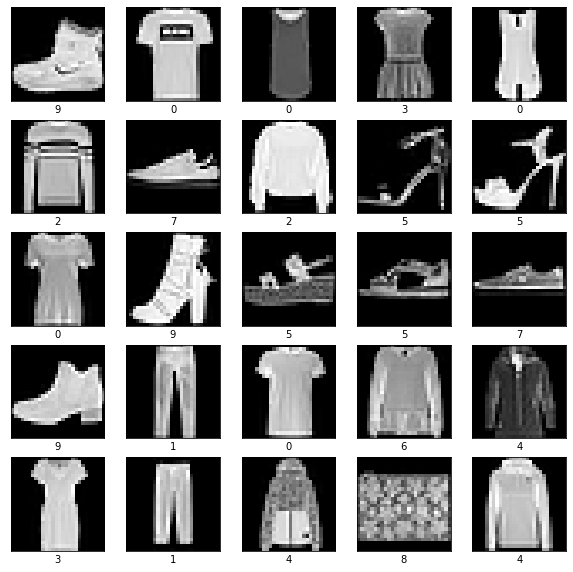

In [11]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [15]:
def SeleccionaClase(train_labels, clases):
    seleccion0 = train_labels == clases[0]
    seleccion1 = train_labels == clases[1]
    seleccion3 = train_labels == clases[2]
    TodosSeleccion = seleccion0 | seleccion1 | seleccion3
    
    entrenaY = train_labels[TodosSeleccion]
    entrenaY[entrenaY == clases[0]] = 0
    entrenaY[entrenaY == clases[1]] = 1
    entrenaY[entrenaY == clases[2]] = 2   
    return TodosSeleccion, entrenaY

In [16]:
def DatosImagen(train_images, filtro):
    entrenaX = np.reshape(train_images, (train_images.shape[0], 28*28))
    return entrenaX[filtro]

In [17]:
llaveEtiqueta, entrenaY = SeleccionaClase(train_labels, [0, 1, 7])
entrenaX = DatosImagen(train_images, llaveEtiqueta)

In [67]:
N, K = entrenaX.shape
entrenaX = np.column_stack((np.ones(N), entrenaX))

In [32]:
diccionarioClases = {0 : "T-shirt/top", 1 : "Trouser", 2 : "Sneaker"}

In [101]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    X = tf.placeholder(tf.float32, shape = (None, K+1), name = "X")
    etiquetasY = tf.placeholder(tf.int32, name = "etiquetasY")
    lr = tf.placeholder(tf.float32, name = "LearningRate")
    peso = tf.Variable(tf.truncated_normal(shape = [K+1, 3]), name = "Pesos")
   
    with tf.name_scope("Logits"):
        Logits = tf.matmul(X, peso, name = "Logits") 
        YpredichoSombrerito = tf.nn.softmax(Logits, name = "YpredichoSombrerito")

    with tf.name_scope("CalculoCosto"):
        costo = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = etiquetasY, logits = Logits), name = "Costo")

    with tf.name_scope("GradientDescentOptimizer"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(costo) 
        
    with tf.name_scope("Exactitud"):
        correctPredictions = tf.equal(etiquetasY, tf.argmax(YpredichoSombrerito, 1, output_type = tf.int32), name = "Prediccion_Correcta")
        exactitud = tf.reduce_mean(tf.cast(correctPredictions, tf.float32), name = "exactitud")
        
    with tf.name_scope("Resumen"):
        Resumen_Costo = tf.summary.scalar(name='Costo', tensor = costo)
        Resumen_exactitud = tf.summary.scalar(name='exactitud', tensor = exactitud)
        summaries = tf.summary.merge_all()
    init = tf.global_variables_initializer()

In [63]:
def CantidadLote(x, tamanioLote, totalLote, numeroLote):
    if numeroLote < totalLote:
        return x[tamanioLote*numeroLote:tamanioLote*(numeroLote+(numeroLote*K))]
    else:
        return x[tamanioLote*totalLote:]

In [161]:
logs_dir = r"C:\Users\diego\StatisticalLearning\Practica4\logs"

def EntrenamientoModeloLineal(x, y, epochsEntrenamiento, tamanioDelLote, LearningRate, imprimirCada, tag):
    totalLote = (x.shape[0] // tamanioDelLote)
    horaInicio = time.time()
    with tf.Session(graph = g) as sess: 
        writer = tf.summary.FileWriter(logs_dir, sess.graph)
        sess.run(init) 
        for epoch in range(epochsEntrenamiento): 
            for lote in range(totalLote):
                LoteX = CantidadLote(x, tamanioDelLote, totalLote, lote)
                LoteY = CantidadLote(y, tamanioDelLote, totalLote, lote)
                _, summ = sess.run([optimizer, summaries], feed_dict = {X : LoteX, etiquetasY : LoteY, lr : LearningRate})

                writer.add_summary(summ, epoch*totalLote + lote + 1)

                if (lote + 1) % imprimirCada == 0: 
                    c = sess.run(costo, feed_dict = {X : LoteX, etiquetasY : LoteY})
                    print("Epoch = %d,\t\tNo. Batch = %d,\tCosto: %0.4f" % (epoch, lote+1, c))

        writer.close()
        pesos = sess.run(peso)
    horaFinal = time.time()
    print("Tiempo transcurrido: %0.2f segundos. " % (horaFinal-horaInicio))
    return (pesos)

In [162]:
def predecir(x, pesos):
        logits = np.matmul(x, pesos)
        y = np.argmax(logits)
        return diccionarioClases[y]

In [163]:
#CantidadLote(entrenaX, 32, 562, 0).shape
#CantidadLote(entrenaX, 32, 562, 1).shape
#CantidadLote(entrenaX, 32, 562, 561).shape
#CantidadLote(entrenaY, 32, 562, 1).shape
#entrenaY
#{X : LoteX, etiquetasY : LoteY, lr : LearningRate}
F_th = EntrenamientoModeloLineal(entrenaX, entrenaY, 2, 32, 0.01, imprimirCada=60, tag='crudos')

Epoch = 0,		No. Batch = 60,	Costo: 28.2813
Epoch = 0,		No. Batch = 120,	Costo: 20.9949
Epoch = 0,		No. Batch = 180,	Costo: 15.8941
Epoch = 0,		No. Batch = 240,	Costo: 13.2428
Epoch = 0,		No. Batch = 300,	Costo: 12.8887
Epoch = 0,		No. Batch = 360,	Costo: 10.9687
Epoch = 0,		No. Batch = 420,	Costo: 12.7622
Epoch = 0,		No. Batch = 480,	Costo: 38.1828
Epoch = 0,		No. Batch = 540,	Costo: 0.0000
Epoch = 1,		No. Batch = 60,	Costo: 15.3370
Epoch = 1,		No. Batch = 120,	Costo: 12.0287
Epoch = 1,		No. Batch = 180,	Costo: 9.1311
Epoch = 1,		No. Batch = 240,	Costo: 7.4239
Epoch = 1,		No. Batch = 300,	Costo: 7.0642
Epoch = 1,		No. Batch = 360,	Costo: 5.4162
Epoch = 1,		No. Batch = 420,	Costo: 2.5741
Epoch = 1,		No. Batch = 480,	Costo: 0.7772
Epoch = 1,		No. Batch = 540,	Costo: 0.0000
Tiempo transcurrido: 39.55 segundos. 


Imagenes:  [17166  8086 13926 10081 14446  9877   694  9300  5603  6449]


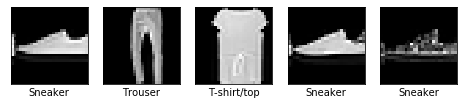

In [164]:
s = np.random.randint(0, N, 10)
random_x = entrenaX[s]
print("Imagenes: ",s)

plt.figure(figsize = (8,8))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    imagen = random_x[i, 1:785].reshape((28,28))
    plt.imshow(imagen, cmap = 'gray')
    plt.xlabel(predecir(random_x[i], F_th))

In [170]:
%reload_ext tensorboard
%tensorboard --logdir="C:\Users\diego\StatisticalLearning\Practica4\logs" --port=6010

Reusing TensorBoard on port 6010 (pid 40720), started 0:03:15 ago. (Use '!kill 40720' to kill it.)

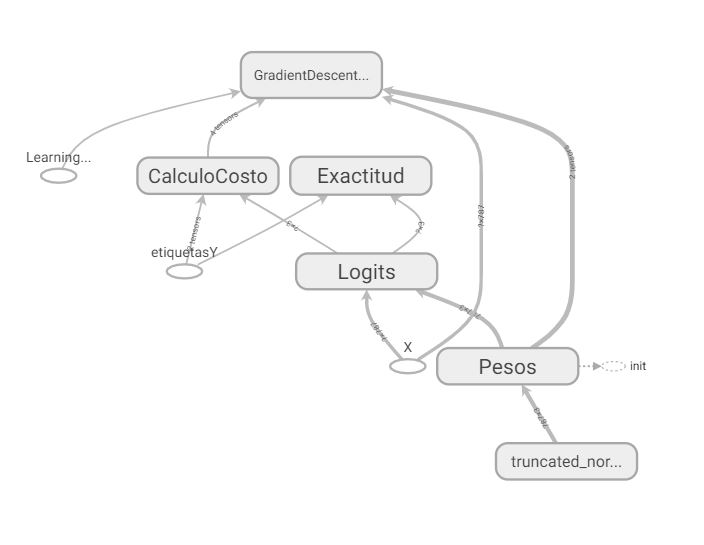

In [172]:
from IPython.display import Image
Image(filename="grafo.jpg")

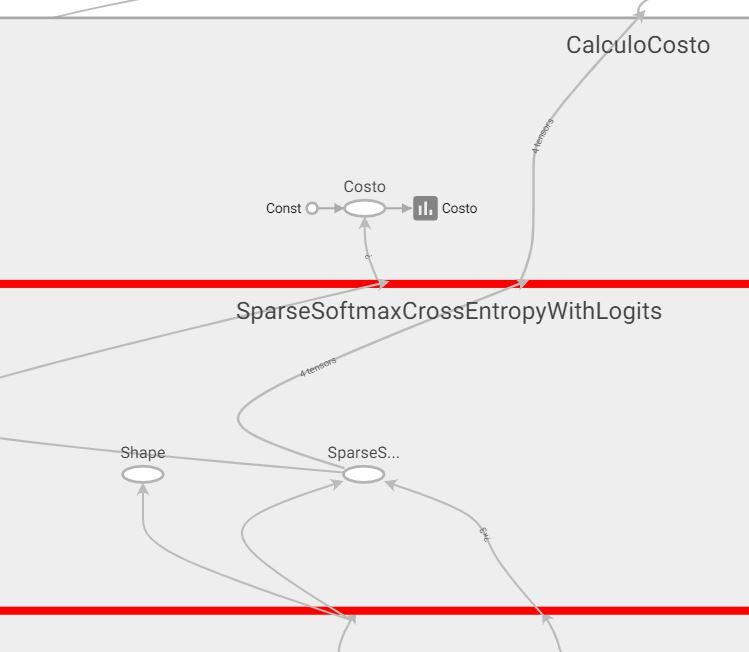

In [173]:
Image(filename="calculoCosto.jpg")

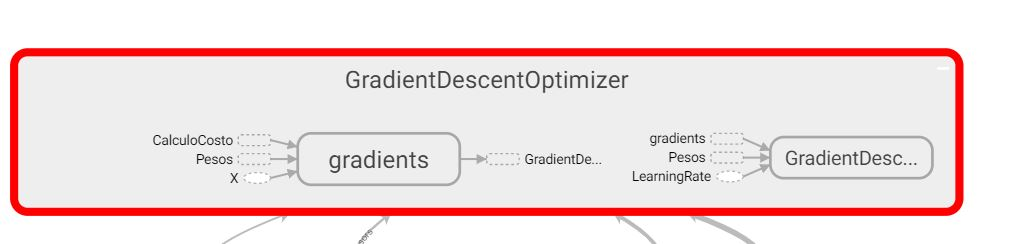

In [174]:
Image(filename="gradientDescent.jpg")

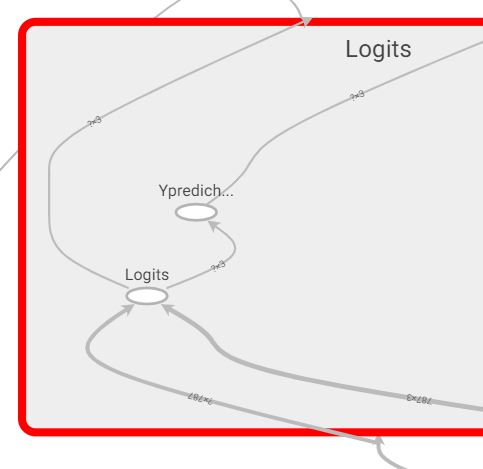

In [175]:
Image(filename="logits.jpg")

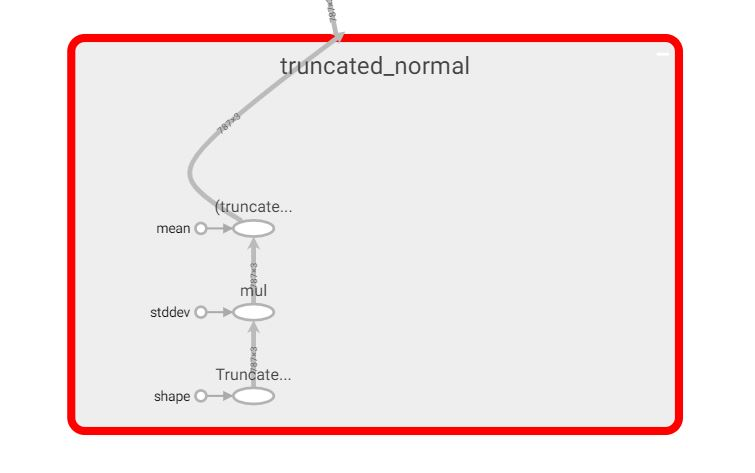

In [176]:
Image(filename="truncatedNormal.jpg")

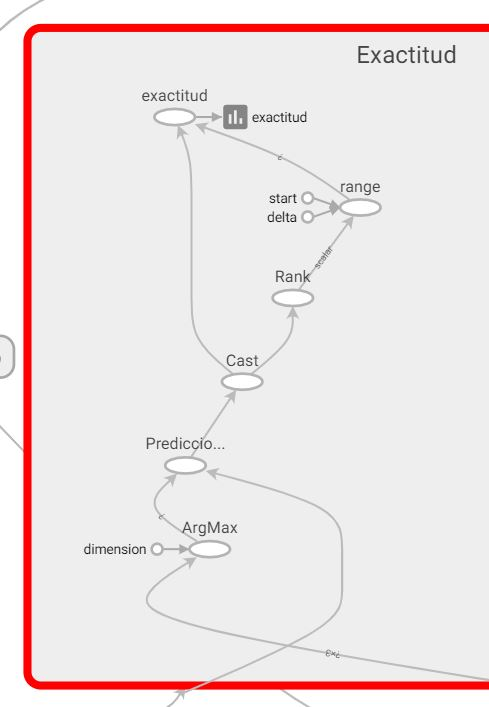

In [177]:
Image(filename="exactitud.jpg")

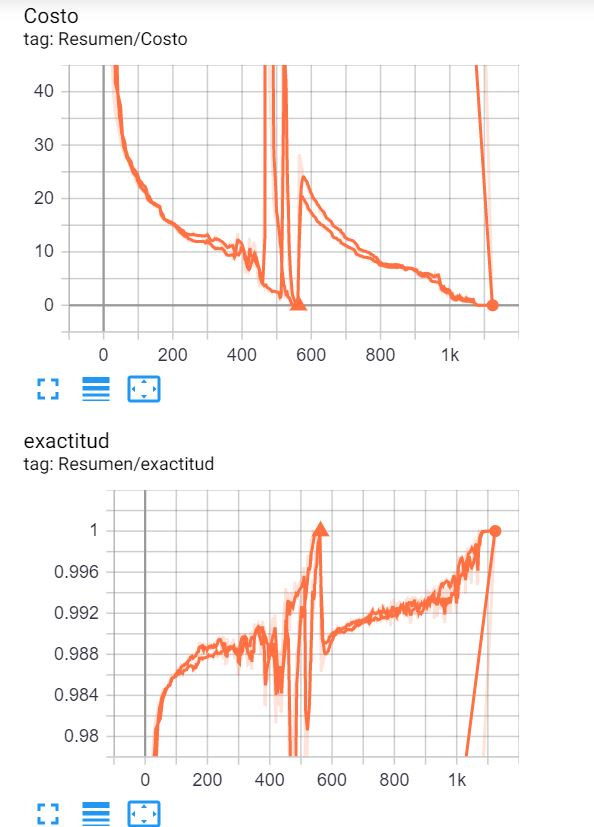

In [178]:
Image(filename="costoYExactitud.jpg")

In [179]:
normal = entrenaX.copy()
normal[:, 1:] = normal[:, 1:]
normal

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [180]:
F_thRenorm = EntrenamientoModeloLineal(normal, entrenaY, 2, 32, 0.01, imprimirCada = 60, tag = 'renorm')

Epoch = 0,		No. Batch = 60,	Costo: 51.2826
Epoch = 0,		No. Batch = 120,	Costo: 34.2127
Epoch = 0,		No. Batch = 180,	Costo: 26.2246
Epoch = 0,		No. Batch = 240,	Costo: 22.2630
Epoch = 0,		No. Batch = 300,	Costo: 21.3874
Epoch = 0,		No. Batch = 360,	Costo: 18.3510
Epoch = 0,		No. Batch = 420,	Costo: 15.2671
Epoch = 0,		No. Batch = 480,	Costo: 10.0922
Epoch = 0,		No. Batch = 540,	Costo: 0.4237
Epoch = 1,		No. Batch = 60,	Costo: 12.0851
Epoch = 1,		No. Batch = 120,	Costo: 9.8046
Epoch = 1,		No. Batch = 180,	Costo: 7.4056
Epoch = 1,		No. Batch = 240,	Costo: 6.2844
Epoch = 1,		No. Batch = 300,	Costo: 6.4103
Epoch = 1,		No. Batch = 360,	Costo: 5.4868
Epoch = 1,		No. Batch = 420,	Costo: 4.3953
Epoch = 1,		No. Batch = 480,	Costo: 2.2248
Epoch = 1,		No. Batch = 540,	Costo: 0.0000
Tiempo transcurrido: 40.05 segundos. 


Imágenes:  [17309 17116  1131 12014  8386]


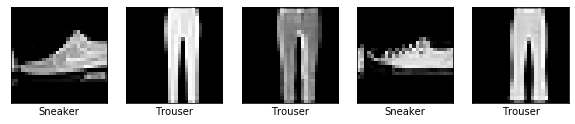

In [182]:
nuevosAleatorios = np.random.randint(0, N, 5)
random_x = normal[nuevosAleatorios]
print("Imágenes: ",nuevosAleatorios)


plt.figure(figsize = (10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = random_x[i, 1:785].reshape((28,28))
    plt.imshow(img, cmap = 'gray')
    plt.xlabel(predecir(random_x[i], F_thRenorm))

In [183]:
%tensorboard --logdir="C:\Users\diego\StatisticalLearning\Practica4\logs" --port=6010

Reusing TensorBoard on port 6010 (pid 40720), started 0:21:29 ago. (Use '!kill 40720' to kill it.)

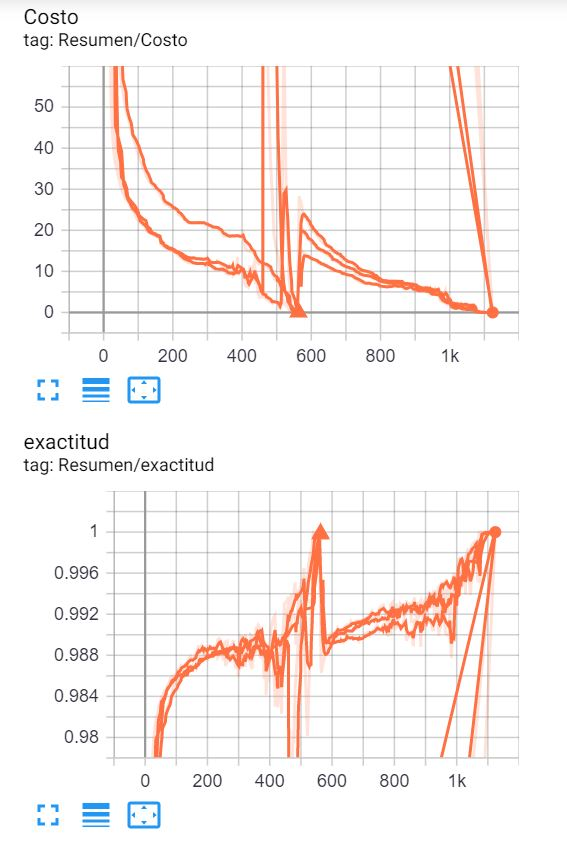

In [184]:
Image(filename="costoExactitud2.jpg")

In [186]:
llaveEtiqueta, valoresPruebaEtiqueta = SeleccionaClase(test_labels, [0, 1, 7])
ImagenNuevaX = DatosImagen(test_images, llaveEtiqueta)
ImagenNuevaX = np.column_stack((np.ones(ImagenNuevaX.shape[0]), ImagenNuevaX))

In [224]:
def predecirEtiquetas(pruebaX, F_th):
    u = tf.Graph()
    with u.as_default():
        X = tf.placeholder(tf.float32, shape = (None, K-2), name = "X")
        peso = tf.placeholder(tf.float32, shape = (K-2, 3), name = "peso")
        with tf.name_scope("Logits"):
            Logits = tf.matmul(X, peso, name = "Logits") 
            YpredichoSombrerito = tf.argmax(tf.nn.softmax(Logits), 1, output_type = tf.int32, name = "YpredichoSombrerito")

    with tf.Session(graph = u) as sess:
        prediccion = sess.run(YpredichoSombrerito, feed_dict = {X : pruebaX, peso : F_th})
    
    return prediccion

In [228]:
 def nuevaAccion(pruebaX, YtrueLabels, F_th):
    nuevaPrediccion = predecirEtiquetas(pruebaX, F_th)
    acc = np.mean(np.equal(nuevaPrediccion, YtrueLabels))
    print("Precisión en la predicción de: %0.2f%%" % (acc*100))
    return acc

In [229]:
nuevaAccion(ImagenNuevaX, valoresPruebaEtiqueta, F_th)

ValueError: Cannot feed value of shape (3000, 785) for Tensor 'X:0', which has shape '(?, 784)'